In [6]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, norm
import seaborn as sns
import math

plt.rcParams['font.family'] = 'Helvetica'
group_palette = ["#96BCE0", "#926AAD", "#AFC286", "#B8772F"]
method_palette = ["#A64C4D", "#40609B"]
CAPSIZE = 0.05
ERRWIDTH = 1.5
RESULTS_DIR = pathlib.Path("../data/results")
FIGURES_DIR = pathlib.Path("../data/figures")
KM = r"$K_M$"
KCAT = r"$k_{cat}$"
GB = "Gradient Boosting"
BMM = "Bayesian Multilevel Models"

### Load validation data.

In [7]:
dfs = []
for f in RESULTS_DIR.glob("*.csv"):
    _, grouping, fold = f.stem.split("_")
    df = pd.read_csv(f)
    df["grouping"] = grouping.capitalize()
    df["fold"] = fold
    dfs.append(df)
results_df = pd.concat(dfs, ignore_index=True)
results_df["err_ratio"] = results_df["error"] / results_df["pred_error"]

groups_df = results_df.groupby(["type", "grouping", "fold"])
stats_df = groups_df.agg(
    rmse=("error", lambda x: np.sqrt(np.mean(x ** 2))),
    pred_rmse=("pred_error", lambda x: np.sqrt(np.mean(x ** 2))),
    nrmse=("err_ratio", lambda x: np.sqrt(np.mean(x ** 2))),
    uncertainty_error=("err_ratio", lambda x: (1 - np.sqrt(np.mean(x ** 2))) * 100)
)
stats_df["pearson"] = groups_df.apply(
    lambda x : pearsonr(x["value_log10"], x["pred_value"])[0]
)
stats_df["r2"] = groups_df.apply(
    lambda x : np.corrcoef(x["value_log10"], x["pred_value"])[0, 1] ** 2
)
stats_df = stats_df.reset_index()
stats_df.replace({"type": {"km": KM, "kcat": KCAT}}, inplace=True)
stats_df

type     grouping fold      rmse  pred_rmse     nrmse  \
0   $k_{cat}$       Family    0  1.340498   1.319215  1.023461   
1   $k_{cat}$       Family    1  1.305502   1.327872  1.003784   
2   $k_{cat}$       Family    2  1.538623   1.333771  1.176644   
3   $k_{cat}$       Family    3  1.302998   1.326175  1.005111   
4   $k_{cat}$       Family    4  1.369689   1.308161  1.071886   
5   $k_{cat}$  Measurement    0  0.856133   0.910328  1.119767   
6   $k_{cat}$      Protein    0  1.305507   1.202128  1.125486   
7   $k_{cat}$      Protein    1  1.204776   1.213935  1.048836   
8   $k_{cat}$      Protein    2  1.248739   1.235011  1.047591   
9   $k_{cat}$      Protein    3  1.242304   1.199973  1.066562   
10  $k_{cat}$      Protein    4  1.212981   1.229365  1.016925   
11  $k_{cat}$     Reaction    0  1.418620   1.412891  1.007301   
12  $k_{cat}$     Reaction    1  1.612431   1.421042  1.133834   
13  $k_{cat}$     Reaction    2  1.496982   1.416189  1.056215   
14  $k_{cat}$     Reaction    3  1.428077   1.415690  1.007961   
15  $k_{cat}$     Reaction    4  1.466609   1.414230  1.043113   
16      $K_M$       Family    0  0.984942   0.974830  1.026112   
17      $K_M$       Family    1  0.949118   0.965852  1.014463   
18      $K_M$       Family    2  0.975002   0.971443  1.017096   
19      $K_M$       Family    3  0.971315   0.969663  1.031856   
20      $K_M$       Family    4  0.987513   0.965912  1.046425   
21      $K_M$  Measurement    0  0.694616   0.707033  1.073491   
22      $K_M$      Protein    0  0.896842   0.882969  1.042342   
23      $K_M$      Protein    1  0.898496   0.896513  1.018899   
24      $K_M$      Protein    2  0.896120   0.895060  1.029588   
25      $K_M$      Protein    3  0.894715   0.885568  1.031354   
26      $K_M$      Protein    4  0.894940   0.885261  1.028399   
27      $K_M$     Reaction    0  1.146190   1.083990  1.068649   
28      $K_M$     Reaction    1  1.072523   1.089549  0.992783   
29      $K_M$     Reaction    2  1.090458   1.079811  1.017829   
30      $K_M$     Reaction    3  1.114023   1.082533  1.037760   
31      $K_M$     Reaction    4  1.079563   1.083237  0.999430   

    uncertainty_error   pearson        r2  
0           -2.346105  0.484296  0.234542  
1           -0.378422  0.457259  0.209085  
2          -17.664431  0.463539  0.214869  
3           -0.511108  0.480724  0.231095  
4           -7.188603  0.494105  0.244140  
5          -11.976666  0.832874  0.693679  
6          -12.548560  0.548913  0.301305  
7           -4.883554  0.614959  0.378175  
8           -4.759138  0.603580  0.364308  
9           -6.656176  0.602891  0.363478  
10          -1.692530  0.648594  0.420674  
11          -0.730139  0.276835  0.076638  
12         -13.383439  0.372040  0.138414  
13          -5.621511  0.330130  0.108986  
14          -0.796130  0.342443  0.117267  
15          -4.311295  0.342437  0.117263  
16          -2.611210  0.643182  0.413683  
17          -1.446311  0.623063  0.388207  
18          -1.709639  0.621192  0.385879  
19          -3.185561  0.633435  0.401240  
20          -4.642470  0.640996  0.410875  
21          -7.349132  0.833848  0.695303  
22          -4.234248  0.702939  0.494124  
23          -1.889937  0.697360  0.486311  
24          -2.958784  0.696685  0.485370  
25          -3.135413  0.702718  0.493813  
26          -2.839864  0.703024  0.494243  
27          -6.864938  0.457118  0.208957  
28           0.721724  0.536859  0.288218  
29          -1.782922  0.508991  0.259072  
30          -3.776017  0.454320  0.206407  
31           0.057008  0.526890  0.277613

### 

In [8]:
stats_df.groupby(["type", "grouping"]).mean()

C:\Users\gollubm\AppData\Local\Temp/ipykernel_8784/2958909037.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stats_df.groupby(["type", "grouping"]).mean()


rmse  pred_rmse     nrmse  uncertainty_error  \
type      grouping                                                        
$K_M$     Family       0.973578   0.969540  1.027190          -2.719038   
          Measurement  0.694616   0.707033  1.073491          -7.349132   
          Protein      0.896222   0.889074  1.030116          -3.011649   
          Reaction     1.100551   1.083824  1.023290          -2.329029   
$k_{cat}$ Family       1.371462   1.323039  1.056177          -5.617734   
          Measurement  0.856133   0.910328  1.119767         -11.976666   
          Protein      1.242861   1.216082  1.061080          -6.107991   
          Reaction     1.484544   1.416008  1.049685          -4.968503   

                        pearson        r2  
type      grouping                         
$K_M$     Family       0.632373  0.399977  
          Measurement  0.833848  0.695303  
          Protein      0.700545  0.490772  
          Reaction     0.496836  0.248053  
$k_{cat}$ Family       0.475984  0.226746  
          Measurement  0.832874  0.693679  
          Protein      0.603787  0.365588  
          Reaction     0.332777  0.111714

In [9]:
dfs = []
for f in (RESULTS_DIR / "kroll_2021").glob("*.csv"):
    _, fold = f.stem.split("_")
    df = pd.read_csv(f)
    df["type"] = KM
    df["fold"] = fold
    dfs.append(df)
for f in (RESULTS_DIR / "kroll_2022").glob("*.csv"):
    _, fold = f.stem.split("_")
    df = pd.read_csv(f)
    df["type"] = KCAT
    df["fold"] = fold
    dfs.append(df)
kroll_results_df = pd.concat(dfs, ignore_index=True)

groups_df = kroll_results_df.groupby(["type", "fold"])
kroll_comparison_df = groups_df.apply(
    lambda x : pearsonr(x["value"], x["pred_value"])[0]
).rename("pearson").to_frame()
kroll_comparison_df["r2"] = groups_df.apply(
    lambda x : np.corrcoef(x["value"], x["pred_value"])[0, 1] ** 2
)
kroll_comparison_df = kroll_comparison_df.reset_index()
kroll_comparison_df["method"] = BMM
kroll_comparison_df = pd.concat([kroll_comparison_df, pd.DataFrame({
    "type": [KM, KCAT],
    "method": [GB, GB],
    "fold": [0, 0],
    "pearson": [np.nan, np.nan],
    "r2": [0.53, 0.40]
})])

kroll_comparison_df

type fold   pearson        r2                      method
0      $K_M$    0  0.669418  0.448121  Bayesian Multilevel Models
1      $K_M$    1  0.684078  0.467963  Bayesian Multilevel Models
2      $K_M$    2  0.673866  0.454095  Bayesian Multilevel Models
3      $K_M$    3  0.690826  0.477241  Bayesian Multilevel Models
4      $K_M$    4  0.680330  0.462849  Bayesian Multilevel Models
5  $k_{cat}$    0  0.654131  0.427887  Bayesian Multilevel Models
6  $k_{cat}$    1  0.636180  0.404725  Bayesian Multilevel Models
7  $k_{cat}$    2  0.621094  0.385758  Bayesian Multilevel Models
8  $k_{cat}$    3  0.609854  0.371922  Bayesian Multilevel Models
9  $k_{cat}$    4  0.572508  0.327766  Bayesian Multilevel Models
0      $K_M$    0       NaN  0.530000           Gradient Boosting
1  $k_{cat}$    0       NaN  0.400000           Gradient Boosting

In [15]:
stats_df.loc[(stats_df["type"] == KCAT) & (stats_df["grouping"] == "Measurement"),"rmse"].iloc[0]

0.8561326594064995

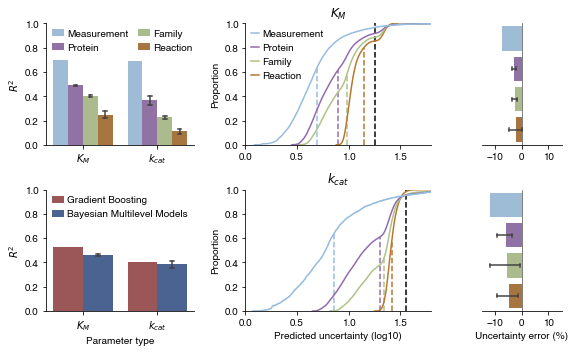

In [16]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2, 3, figsize=(8, 5), width_ratios=[2.8, 3.5, 1.5])

type_order = [KM, KCAT]
groups_order = ["Measurement", "Protein", "Family", "Reaction"]
methods_order = [GB, BMM]

# Coefficient of determination with different splits.
sns.barplot(
    data=stats_df, x="type", y="r2", hue="grouping",
    ax=ax0, palette=group_palette, order=type_order, hue_order=groups_order,
    capsize=CAPSIZE, errwidth=ERRWIDTH)
ax0.set_xlabel("")
ax0.set_ylim(0, 1.0)
ax0.set_ylabel(r"$R^2$")
sns.move_legend(ax0, "upper left", frameon=False, title=None, ncols=2, handlelength=1.2,
                handletextpad=0.3, columnspacing=1.0, borderpad=0.1)
sns.despine(ax=ax0)

# Comparison with the Kroll papers.
sns.barplot(
    data=kroll_comparison_df, x="type", y="r2", hue="method",
    ax=ax3, palette=method_palette, order=type_order, hue_order=methods_order,
    capsize=CAPSIZE, errwidth=ERRWIDTH)
ax3.set_xlabel("Parameter type")
ax3.set_ylim(0, 1.0)
ax3.set_ylabel(r"$R^2$")
sns.move_legend(ax3, "upper left", frameon=False, title=None, handlelength=1.2,
                handletextpad=0.3, borderpad=0.1)
sns.despine(ax=ax3)

# Distribution of prediction uncertainties with different splits.
ax1.axvline(np.std(results_df[results_df["type"] == "km"]["value_log10"]), color="black", linestyle="--")
for i, g in enumerate(groups_order):
    errors = results_df[(results_df["type"] == "km") & (results_df["grouping"] == g)]["pred_error"]
    # x = np.sqrt(np.mean(errors ** 2))
    x = stats_df[(stats_df["type"] == KM) & (stats_df["grouping"] == g)]["rmse"].iloc[0]
    ax1.axvline(x, color=group_palette[i], linestyle="--", ymax=sum(errors < x) / len(errors))
sns.ecdfplot(
    data=results_df[results_df["type"] == "km"], x="pred_error", hue="grouping", 
    ax=ax1, hue_order=groups_order, palette=group_palette)
ax1.set_xlim(0, 1.8)
ax1.set_title(KM)
ax1.set_xlabel("")
ax1.get_legend().set_title("")
ax1.get_legend().set_frame_on(False)
sns.move_legend(ax1, "upper left", frameon=False, title=None, handlelength=0.8,
                handletextpad=0.3, borderpad=0.1)
sns.despine(ax=ax1)

ax4.axvline(np.std(results_df[results_df["type"] == "kcat"]["value_log10"]), color="black", linestyle="--")
for i, g in enumerate(groups_order):
    errors = results_df[(results_df["type"] == "kcat") & (results_df["grouping"] == g)]["pred_error"]
    # x = np.sqrt(np.mean(errors ** 2))
    x = stats_df[(stats_df["type"] == KCAT) & (stats_df["grouping"] == g)]["rmse"].iloc[0]
    ax4.axvline(x, color=group_palette[i], linestyle="--", ymax=sum(errors < x) / len(errors))
sns.ecdfplot(
    data=results_df[results_df["type"] == "kcat"], x="pred_error", hue="grouping",
    ax=ax4, hue_order=groups_order, palette=group_palette, legend=False)
ax4.set_xlim(0, 1.8)
ax4.set_title(KCAT)
ax4.set_xlabel("Predicted uncertainty (log10)")
sns.despine(ax=ax4)

# Error in the predicted uncertainties.
ax2.axvline(0, color="black", linestyle="-", linewidth=0.5)
sns.barplot(
    data=stats_df[stats_df["type"] == KM], x="uncertainty_error", y="grouping",
    ax=ax2, order=groups_order, palette=group_palette,
    capsize=CAPSIZE*2, errwidth=ERRWIDTH)
ax2.set_xlim(-15, 15)
ax2.set_xlabel("")
ax2.yaxis.set_visible(False)
sns.despine(ax=ax2)
ax2.spines["left"].set_visible(False)
ax5.axvline(0, color="black", linestyle="-", linewidth=0.5)
sns.barplot(
    data=stats_df[stats_df["type"] == KCAT], x="uncertainty_error", y="grouping",
    ax=ax5, order=groups_order, palette=group_palette,
    capsize=CAPSIZE*2, errwidth=ERRWIDTH)
ax5.set_xlim(-15, 15)
ax5.set_xlabel("Uncertainty error (%)")
ax5.set_yticks([])
ax5.yaxis.set_visible(False)
sns.despine(ax=ax5)
ax5.spines["left"].set_visible(False)

fig.tight_layout()
fig.savefig(FIGURES_DIR / "cv_results.pdf", bbox_inches="tight")